In [1]:
# JM, 17 Mar 2018
#
# plot the barotropic streamfunction
# calculates it from a subfunction adapted from CDFTOOLS/cdfpsi.f90
#
%matplotlib inline

from orca_plotting_commands import *
from matplotlib_colorbar import *

import matplotlib as mpl
import matplotlib.pyplot as plt

import netCDF4
# need iris if wanting to use cartopy_command
import iris
import iris.analysis.cartography

# for editing
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from pyCDFTOOLS.cdfpsi import *

figure_save = False

In [11]:
#data_dir = "/network/group/aopp/oceans/DPM004_MAK_GEOMET/NEMO_data/eORCA1_LIM3/L46/"
data_dir = "/home/mak/Downloads/eORCA1-tuning/alp_004/"
file_U = "eORCA1_10y_08610101_08701231_grid_U.nc"
file_V = file_U.replace("_U", "_V")

# for putting extra options in
#   -- kt       = number for using a specified time entry
#   -- lprint   = True   for printing out variable names in netcdf file
#   -- ll_v     = True   for using V instead of the default U
#   -- lg_vvl   = True   for using s-coord (time-varying metric)
#   -- i[ij]ref = number for using a different normalising reference (need both to be specified)
kwargs = {"lprint" : False,
          "ll_v"   : False,
          "lg_vvl" : True}

lonT, latT, psi, opt_dic = cdfpsi(data_dir, file_U, "uo", file_V, "vo", **kwargs)
#lonT, latT, psi = cdfpsi(data_dir, fileU, "vozocrtx", fileV, "vomecrty", **kwargs)

In [38]:
import matplotlib.tri as tri
triang = tri.Triangulation(lonT.flatten(), latT.flatten())
mask = np.where(psi.flatten(), 1, 0)

len(lonT.flatten())
#plt.tricontourf(lonT.flatten(), latT.flatten(), psi.flatten())

120184

In [17]:
# load in iris and defined some generic things
iris.FUTURE.netcdf_promote = True

pcarree = ccrs.PlateCarree()

target_proj = ccrs.PlateCarree()
#target_proj = ccrs.Orthographic(central_longitude=0, central_latitude=-90)
#target_proj = ccrs.Mercator()
#target_proj = ccrs.Robinson()
#target_proj = ccrs.Mollweide()

lat = iris.coords.AuxCoord(latT, standard_name = "latitude", units = "degrees")
lon = iris.coords.AuxCoord(lonT, standard_name = "longitude", units = "degrees")
data_cube = iris.cube.Cube(psi, 
                           long_name = "Psi", 
                           units = "Sv",
                           aux_coords_and_dims = [(lat, (0, 1)), (lon, (0,1))])
data_proj, extent = iris.analysis.cartography.project(data_cube[:, :], pcarree, nx = 400, ny = 200)
x = data_proj.coord('projection_x_coordinate').points
y = data_proj.coord('projection_y_coordinate').points
plot_data = data_proj.data / 1e6 # in Sv

/home/mak/anaconda3/envs/py3/lib/python3.6/site-packages/iris/analysis/cartography.py:596: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
  warnings.warn('Coordinate system of latitude and longitude '


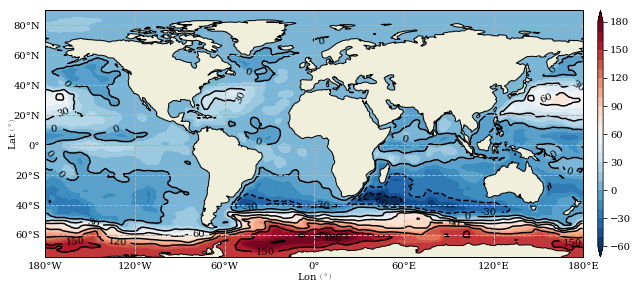

In [19]:
# touch up the data and set levels
# "mask" the data by setting the land point data

plot_data[(plot_data == 0)] = np.nan

if type(target_proj).__name__ in ["Orthographic"]:
    if figure_save:
        fig = plt.figure(figsize=(5, 5), dpi = 300)
    else:
        fig = plt.figure(figsize=(5, 5))
else:
    if figure_save:
        fig = plt.figure(figsize=(10, 7), dpi = 300)
    else:
        fig = plt.figure(figsize=(10, 7))

# plot denser colour contours
misc_format = {"levels" : np.arange(-60, 190, 10),
               "extend" : "both"}
ax, mesh = cartopy_contourf(x, y, plot_data, target_proj, **misc_format)

# plot more sparse line contours
misc_format = {"levels" : np.arange(-60, 190, 30),
               "extend" : "both"}
line = plt.contour(x, y, plot_data, transform = pcarree, colors = "k", **misc_format)
plt.clabel(line, fmt = r"%2.0f", colors = 'k')

# set axes, title and add gridlines

#plt.title(r'Temperature ($t = %.2f $ yrs)' % (time_vec[kt] / 360))
#plt.title(r'barotropic streamfunction')

if type(target_proj).__name__ not in ["Orthographic"]:
    ax.set_extent([-180, 180, -75, 90], crs = pcarree)

ax.gridlines(linewidth = 1, linestyle = '--')

if type(target_proj).__name__ in ["PlateCarree", "Mercator"]:
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels = True, linewidth = 1, linestyle = '--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.text(-0.05, 0.5, r'Lat $\left( {}^\circ \right)$', 
            va='bottom', ha='center',
            rotation=90, rotation_mode='anchor',
            transform=ax.transAxes)
    ax.text(0.5, -0.1, r'Lon $\left( {}^\circ \right)$', 
            va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes)

# add colorbar
divider = make_axes_locatable(ax)
if type(target_proj).__name__ in ["Orthographic", "Robinson", "Mollweide"]:
    ax_cb = divider.new_vertical(size="2%", pad=0.2, pack_start=True, axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    cb = plt.colorbar(mesh, cax=ax_cb, orientation = "horizontal")
else:
    ax_cb = divider.new_horizontal(size="1%", pad=0.2, axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    cb = plt.colorbar(mesh, cax=ax_cb, orientation = "vertical")

#plt.title(r'${}^\circ \mathrm{C}$') # title on colourbar

figure_save = False
if figure_save:
    fig.savefig('./psi_barotropic.pdf', bbox_inches = "tight")
    #plt.close(fig)

In [ ]:
plt.contourf(lonT, latT, psi / 1e6, 25, cmap = "RdBu_r")
plt.colorbar()

In [16]:
np.nan

nan